Hello to all Russian speakers and everyone interested! 

Recently in the NLP course, I learned that convolutional neural networks can be used to classify text and decided to check this on this wonderful dataset. Let's see what happens :)

In [2]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer

First, import the required libraries and load the data.

In [4]:
from keras.utils import pad_sequences

import re
!pip install pymystem3
from pymystem3 import Mystem

Defaulting to user installation because normal site-packages is not writeable


In [31]:
df = pd.read_csv('labeled.csv')

In [32]:
df.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [33]:
df.shape

(14412, 2)

Now let's create a function that tokenizes the text, removes punctuation marks and English letters from it, and then apply this function to each cell in the DataFrame.


I was given one important advice about this data set, it is better to try not to delete stop words here, they can carry a serious semantic load in the context of comments

In [34]:
def text_cleaner(text):
    tokenized_text = word_tokenize(text, language='russian')
    clean_text = [word.lower() for word in tokenized_text if word not in punctuation and word != '\n']
    r = re.compile("[а-яА-Я]+")
    russian_text = ' '.join([w for w in filter(r.match, clean_text)])
    return russian_text

In [35]:
df['comment'] = df['comment'].apply(lambda x: text_cleaner(x))

Some comments were last links or sets of numbers, so they should have been left blank after clearing the text. I will remove lines containing empty comments

In [36]:
df.loc[df['comment'] == '']

,comment,toxic
28,,0.0
652,,0.0
1007,,0.0
3898,,0.0
4284,,1.0
8665,,0.0
11261,,1.0
13848,,0.0


In [37]:
df = df.drop(df[df['comment'] == ''].index)

In [38]:
df.loc[df['comment'] == '']

,comment,toxic


It's time for lemmatization. Stamming is too harsh with words, in cases of profanity and jargon, it can worsen the situation, so I use lemmatization.



I want to thank the author of this article: https://habr.com/ru/post/503420/, his life hack helped speed up the lemmatization, applying the method not to every cell, but to the whole text, separated by separators

In [39]:
comments = df['comment'].to_numpy()
comments

array(['верблюдов-то за что дебилы бл',
       'хохлы это отдушина затюканого россиянина мол вон а у хохлов еще хуже если бы хохлов не было кисель их бы придумал',
       'собаке собачья смерть', ...,
       'посмотрел утомленных солнцем и оказалось что это хороший фильм такая высокобюджетная артхаусятина к которой могут быть претензии только потому что спиздили-распилили и вообще так не бывает ну нахуй этих критиков обзоры длиннее фильмов петросянство хуже рашкокомедий ебанутая ненависть и доебки по мелочам',
       'крымотред нарушает правила раздела т.к в нем нет обсуждения политики свободное общение это в это тоже самое если я на доске о политике создам тред о том как плохо без тяночки так что уебывайте в б или нвр со своим чатиком престарелых гомосеков',
       'до сих пор пересматриваю его видео орамбо кстати на своем канале пилит похожий контент но качеством похуже там же и шуран не редко светится храню хрупкую надежду что когда-то он вернется такая годнота ведь'],
      dtype=o

In [40]:
lemmatizator = Mystem()
text_for_lemmatization = ' sep '.join(comments)

In [41]:
text_for_lemmatization[:1000]

'верблюдов-то за что дебилы бл sep хохлы это отдушина затюканого россиянина мол вон а у хохлов еще хуже если бы хохлов не было кисель их бы придумал sep собаке собачья смерть sep страницу обнови дебил это тоже не оскорбление а доказанный факт не-дебил про себя во множественном числе писать не будет или мы в тебя верим это ты и твои воображаемые друзья sep тебя не убедил пдф в том что скрипалей отравила россия анализировать и думать пытаешься ватник что ли sep для каких стан является эталоном современная система здравоохранения рф для зимбабве ты тупой хохлы sep в шапке были ссылки на инфу по текущему фильму марвел эти ссылки были заменены на фразу репортим брипидора игнорируем его посты если этого недостаточно чтобы понять что модератор абсолютный неадекват и его нужно лишить полномочий тогда эта борда пробивает абсолютное дно по неадекватности sep упад т там нельзя строить технологий нет разворуют как всегда уже трещинами пош л тупые китазы не могут ничего нормально сделать sep ебать 

In [42]:
lemmatizated_text = lemmatizator.lemmatize(text_for_lemmatization)
lemmatizated_text_list = [word for word in lemmatizated_text if word != ' ' and word != '-']

In [43]:
lemmatizated_text_list[:10]

['верблюд',
 'то',
 'за',
 'что',
 'дебил',
 'бл',
 'sep',
 'хохол',
 'это',
 'отдушина']

In [44]:
lemmatizated_text = ' '.join(lemmatizated_text_list)
lemmatizated_array = np.asarray(lemmatizated_text.split(' sep '))

In [45]:
lemmatizated_array[:10]

array(['верблюд то за что дебил бл',
       'хохол это отдушина затюканый россиянин мол вон а у хохлов еще плохо если бы хохлов не быть кисель они бы придумывать',
       'собака собачий смерть',
       'страница обновлять дебил это тоже не оскорбление а доказывать факт не дебил про себя во множественный число писать не быть или мы в ты верить это ты и твой воображать друг',
       'ты не убеждать пдф в то что скрипалый отравлять россия анализировать и думать пытаться ватник что ли',
       'для какой стан являться эталон современный система здравоохранение рф для зимбабве ты тупой хохол',
       'в шапка быть ссылка на инф по текущий фильм марвести этот ссылка быть заменять на фраза репортить брипидор игнорировать его пост если это недостаточно чтобы понимать что модератор абсолютный неадекват и он нужно лишать полномочие тогда этот борд пробивать абсолютный дно по неадекватность',
       'упад т там нельзя строить технология нет разворовывать как всегда уже трещина пош л тупой китаз 

Replace class labels with integers

In [46]:
df['toxic'] = df['toxic'].astype(int)
labels = df['toxic'].to_numpy()
labels

array([1, 1, 1, ..., 0, 1, 0])

Now split the dataset into training and test data and determine the size of the vocabulary by counting unique words in the training set.
I count words only in the training set to avoid an obvious data leakage

In [47]:
X_train, X_test, y_train, y_test = train_test_split(lemmatizated_array, labels, test_size=0.2, stratify=labels, shuffle=True, random_state=42)

In [48]:
X_train

array(['и просто так тоже не отбирать обязанный быть выплачивать рыночный стоимость а так же возможный потеря прибыль',
       'тег паук не хватать для добавление пост в игнор человек с фобия паук',
       'ничто майдан согнать это все равный на крайний уже случай сша и нато помогать поискать надо в пидорашек химический оружие моль скоро к хусейн и чаушеска отправляться процент пидорашек против конец твой близкий тиран',
       ..., 'свинута давать шебм отрабатывать пайка в минстеця',
       'такой операция и процедура это не новость в питер такой операция уже давно проводить так что никакой сенсация',
       'черт опускать гомикадзе би опускать гей на ебать ссать хуй сосать черт и пиздабол чисто мразь в мазок один ложь и грязь пиздаболище писькамаз х15р угомоняться разорять пригожина'],
      dtype='<U7033')

In [49]:
token_counts = Counter()
for sent in X_train:
    token_counts.update(sent.split(' '))
    
dict_size = len(token_counts.keys())
dict_size

28063

Now, using the keras framework tokenizer, turn the text into a sequence of integers. After that I select the maximum comment length, all comments longer will be truncated, and those that are shorter will be padded

In [50]:
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(X_train)

In [51]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [52]:
max_comment_length = 250
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_comment_length)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_comment_length)

And here it is - the simplest convolutional neural network :)

Let's see if it can handle it. Among the quality metrics, in this case, a high recall is important, because it is better to erroneously react to a normal comment than to skip a toxic one.

In [53]:
max_features = dict_size
embedding_dim = 64


model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_dim, 
                    input_length=max_comment_length))
model.add(Conv1D(filters=embedding_dim*2, 
                 kernel_size=2, 
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))


model.summary()
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 64)           1796032   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 249, 128)          16512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,812,673
Trainable params: 1,812,673
Non-trainable params: 0
_________________________________________________________________


In [54]:
%%time
epochs = 5

history = model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_test), batch_size=512)

Epoch 1/5
23/23 [==============================] - 7s 244ms/step - loss: 0.6334 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6067 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/5
23/23 [==============================] - 5s 237ms/step - loss: 0.5785 - precision_1: 0.9615 - recall_1: 0.0065 - val_loss: 0.5475 - val_precision_1: 0.9011 - val_recall_1: 0.0850
Epoch 3/5
23/23 [==============================] - 5s 227ms/step - loss: 0.4682 - precision_1: 0.9402 - recall_1: 0.3462 - val_loss: 0.4101 - val_precision_1: 0.8847 - val_recall_1: 0.5565
Epoch 4/5
23/23 [==============================] - 6s 245ms/step - loss: 0.3021 - precision_1: 0.9169 - recall_1: 0.7632 - val_loss: 0.3098 - val_precision_1: 0.8831 - val_recall_1: 0.7202
Epoch 5/5
23/23 [==============================] - 5s 227ms/step - loss: 0.1841 - precision_1: 0.9289 - recall_1: 0.8943 - val_loss: 0.2822 - val_precision_1: 0.8685 - val_recall_1: 0.7668
CPU times: user 1min 36s, sys: 547 ms, 

Let's look at the graph of the network error change by epoch.

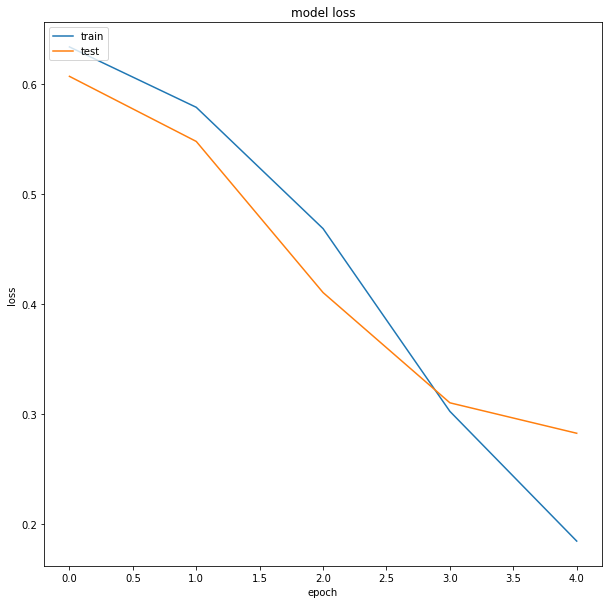

In [55]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Finally, let's look at the predictions

The neural network does a good job on the test set

In [56]:
predictions = model.predict(X_test_padded)
print(predictions[5])

[0.03676483]


In [57]:
y_test[5]

0

And now let's take a random example from the Internet, which is not in our dataset

In [58]:
example = 'прекрасный пример полного отсутствия мозга'
clean_example = text_cleaner(example)
lemm_example = ' '.join(lemmatizator.lemmatize(clean_example))
array_example = np.array([lemm_example])
seq_example = tokenizer.texts_to_sequences(array_example)
pad_example = pad_sequences(seq_example, maxlen=max_comment_length)
pred_example = model.predict(pad_example)
print(pred_example)

[[0.744058]]


Well, looks good!
Thank You for watching :)